In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from collections import Counter
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
from pylab import *
from copy import deepcopy
from PIL import Image
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
import cv2
import numpy as np
from pathlib import Path
from PIL import Image, ImageStat
plt.ion()  

from pylab import rcParams
rcParams['figure.figsize'] = 6,6

device = torch.cuda.is_available()
if device:
    print("Using CUDA")
cuda = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using CUDA


In [0]:
data_dir = '/content/drive/My Drive/Thesis/Elbow/'
TEST = 'test'
TRAIN = 'train'
VAL = 'validate'

data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 4761 images under train
Loaded 635 images under validate
Loaded 173 images under test
Classes: 
['0', '1']


In [0]:
test_dataloader=torch.utils.data.DataLoader(image_datasets[TEST], shuffle=False,num_workers=4)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


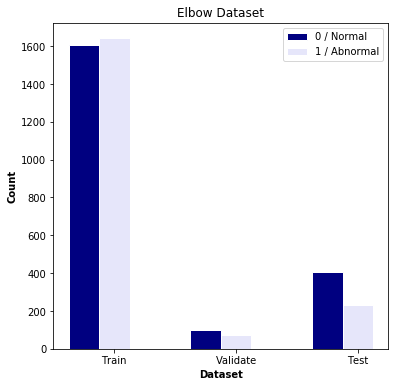

In [0]:
def countSamples(image_datasets):
  zerosList=[]
  onesList=[]
  for x in [TRAIN,TEST, VAL]:
      c=Counter(elem[1] for elem in image_datasets[x].imgs)
      l=list(c.items())
      if l[0][0]==0:
          zerosList.append(l[0][1])
      if l[1][0]==1:
          onesList.append(l[1][1])
  return zerosList,onesList
     
zerosList,onesList=countSamples(image_datasets)

bar1 = np.arange(len(onesList))
bar2 = [x + 0.25 for x in bar1]
plt.bar(bar1, zerosList, color='navy', width= 0.25,edgecolor='white',  label='0 / Normal')
plt.bar(bar2, onesList, color='lavender', width= 0.25, edgecolor='white', label='1 / Abnormal')
N = 3
ind = np.arange(N)
ax = plt.subplot(111)
ax.set_xticks(ind+0.25)
ax.set_xticklabels( ('Train', 'Validate','Test') )
plt.title('Elbow Dataset') 
plt.xlabel('Dataset', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.legend()
#plt.savefig('/content/drive/My Drive/Thesis/Data/Wrist/countplot.png')
plt.show()

<Figure size 720x720 with 0 Axes>

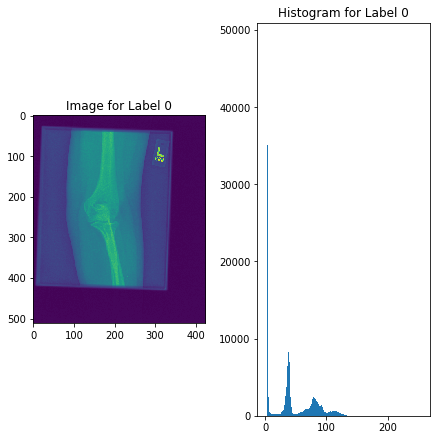

In [0]:
def plotHistograms(image,title):
 
  fig=plt.figure(figsize=(10, 10))
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,constrained_layout=True)
  img=cv2.imread(image,0)
  ax1.imshow(img)
  ax1.set_title("Image for Label %i" % title)  
  
  ax2.hist(img.ravel(),256,[0,256]); 
  ax2.set_title("Histogram for Label %i" % title)
  #fig.savefig('/content/drive/My Drive/Thesis/Data/Wrist/histogram.png')
  plt.show()

img=image_datasets[TRAIN]  
plotHistograms(img.imgs[0][0],img.imgs[0][1])
#plotHistograms(img.imgs[1][0],img.imgs[0][1])

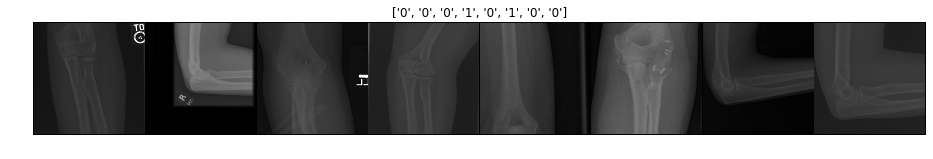

In [0]:
def displayImage(inp,title=None):
   inp = inp.numpy().transpose((1, 2, 0))   
   plt.figure(figsize=(16, 16))
   plt.axis('off')
   plt.imshow(inp)
   if title is not None:
        plt.title(title) 
   plt.pause(0.001)

def displayBatch(img,label):
   out = torchvision.utils.make_grid(img)
   displayImage(out,title=[class_names[x] for x in label])
   #print(out)
img,label=next(iter(dataloaders[TRAIN]))
displayBatch(img,label)

In [0]:
def plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,title):
 
  fig = plt.figure(figsize=(10, 6))
  fig.suptitle(title)
  ax =plt.subplot(1,2,1)

  ax.plot(train_acc_list, label="Train Accuracy")
  ax.plot(val_acc_list, label="Validation Accuracy")
  ax.legend()
  ax.set_xlabel('Number of Epochs')
  ax.set_ylabel("Accuracy")
  ax.set_title("Accuracy Graph")
  
  ax1=plt.subplot(1,2,2)

  ax1.plot(train_loss_list, label="Train Loss")
  ax1.plot(val_loss_list, label="Validation Loss")
  ax1.legend()
  ax1.set_xlabel('Number of Epochs')
  ax1.set_ylabel("Loss")
  ax1.set_title("Loss Graph")
  plt.show()

In [0]:
def train_model(model, criterion, optimizer, num_epochs=20):
    start=time.time()
    result_dict={}
    train_loss_list,train_acc_list=[],[]
    val_loss_list,val_acc_list=[],[]
    f1_score_list=[]
    predicted=[]
    actual=[]
    for epoch in range(num_epochs):
     
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
 
        for phase in [TRAIN,VAL]:
          
            if phase == TRAIN:
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda()
                labels = labels.cuda()
 
                outputs = model(inputs)
                loss = criterion(outputs, labels)
 
                if phase == TRAIN:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
 
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if phase==VAL:
                  #  print("Pred",preds.cpu().numpy())
                  #  print("Lab",labels.cpu().numpy())
                  #  c=labels.cpu().numpy()
                    
                    actual.append(labels.cpu().detach().numpy().tolist())
                    predicted.append(preds.cpu().detach().numpy().tolist())
                
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            
            if phase == TRAIN:
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc) 
                
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
    
    flattened_predicted = [y for x in predicted for y in x]
    flattened_actual = [y for x in actual for y in x]
    f1=f1_score(flattened_predicted, flattened_actual,average='binary')
    print("F1 Score:",f1)    
    time_elapsed = time.time() - start
    
    print('Training complete in (min:sec) : ',int(time_elapsed / 60),'min:', int(time_elapsed % 60),"sec")
    return model,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1

In [0]:
def testModel(model, criterion):

    test_loss = 0.
    correct = 0.
    total = 0.
    predicted_list, actual_list=[],[]
    c=1
    for data, target in test_dataloader:
      
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / ( dataset_sizes[VAL] + 1)) * (loss.data - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            #print(target.cpu().numpy()[0])
            #print(c,pred.cpu().numpy()[0][0],target.cpu().numpy()[0],correct)
            c=c+1
            predicted_list.append(pred.cpu().numpy()[0][0])
            actual_list.append(target.cpu().numpy()[0])
     
    conf_matrix = confusion_matrix(predicted_list, actual_list)
    #print(predicted_list," : ",actual_list)
    print('Test Loss: ',test_loss.cpu().numpy())
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))
    return conf_matrix,predicted_list, actual_list


# Fixed

## ResNet50

In [0]:
model_resnet_50 = models.resnet50(pretrained=True).cuda()
 
for param in model_resnet_50.parameters():
    param.requires_grad = False
 
model_resnet_50.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).cuda()
 
criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(model_resnet_50.fc.parameters(), lr=0.001, momentum=0.9)

In [0]:
model_trained_resnet_50,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(model_resnet_50, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train loss: 0.6498, acc: 0.6276
validate loss: 0.5587, acc: 0.7213
Epoch 2/25
----------
train loss: 0.6106, acc: 0.6686
validate loss: 0.5280, acc: 0.7559
Epoch 3/25
----------
train loss: 0.5987, acc: 0.6858
validate loss: 0.5231, acc: 0.7669
Epoch 4/25
----------
train loss: 0.5923, acc: 0.6856
validate loss: 0.5242, acc: 0.7480
Epoch 5/25
----------
train loss: 0.5804, acc: 0.6984
validate loss: 0.5408, acc: 0.7496
Epoch 6/25
----------
train loss: 0.5872, acc: 0.6925
validate loss: 0.4932, acc: 0.7717
Epoch 7/25
----------
train loss: 0.5768, acc: 0.7009
validate loss: 0.4965, acc: 0.7764
Epoch 8/25
----------
train loss: 0.5837, acc: 0.6931
validate loss: 0.4939, acc: 0.7606
Epoch 9/25
----------
train loss: 0.5750, acc: 0.7022
validate loss: 0.4797, acc: 0.7717
Epoch 10/25
----------
train loss: 0.5647, acc: 0.7020
validate loss: 0.4811, acc: 0.7890
Epoch 11/25
----------
train loss: 0.5652, acc: 0.7080
validate loss: 0.4934, acc: 0.7685
Epoch 12/25
-------

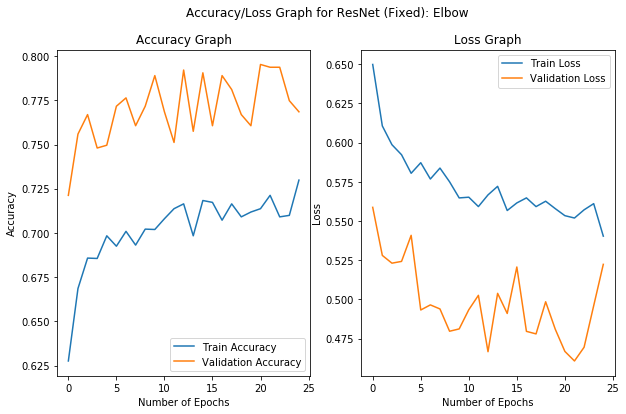

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for ResNet (Fixed): Elbow")

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_resnet_50, criterion)

Test Loss:  0.13241231

Test Accuracy: 75% (131/173)


confusion matrix: [[99 41]
 [ 1 32]]
F1 Score: 0.6037735849056604


Text(33.0, 0.5, 'Predicted Values')

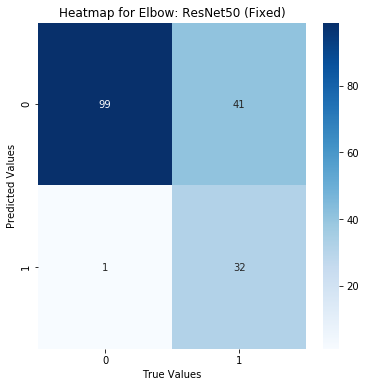

In [0]:
print("confusion matrix:",cm)
print("F1 Score:",f1_score(actual_list,predicted_list))
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap="Blues")
ax.set_title("Heatmap for Elbow: ResNet50 (Fixed)")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
#fig.savefig('/content/drive/My Drive/Thesis/Data/Wrist/heatmapResnet50.png')

In [0]:

torch.save(model_trained_resnet_50.state_dict(),os.path.join(data_dir,'resnet50_Elbow_fixed_1305.pth'))

## ResNet152

In [0]:
model_resnet_152 = models.resnet152(pretrained=True).cuda()
 
for param in model_resnet_152.parameters():
    param.requires_grad = False
 
model_resnet_152.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).cuda()
 
criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(model_resnet_152.fc.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:14, 17110740.26it/s]


In [0]:
model_trained_resnet_152,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(model_resnet_152, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train loss: 0.6678, acc: 0.5794
validate loss: 0.5870, acc: 0.7291
Epoch 2/25
----------
train loss: 0.6280, acc: 0.6349
validate loss: 0.6310, acc: 0.6425
Epoch 3/25
----------
train loss: 0.6162, acc: 0.6567
validate loss: 0.5228, acc: 0.7575
Epoch 4/25
----------
train loss: 0.6200, acc: 0.6512
validate loss: 0.5255, acc: 0.7543
Epoch 5/25
----------
train loss: 0.6007, acc: 0.6659
validate loss: 0.5145, acc: 0.7591
Epoch 6/25
----------
train loss: 0.5955, acc: 0.6736
validate loss: 0.5090, acc: 0.7433
Epoch 7/25
----------
train loss: 0.5960, acc: 0.6817
validate loss: 0.5172, acc: 0.7811
Epoch 8/25
----------
train loss: 0.6031, acc: 0.6552
validate loss: 0.5342, acc: 0.7543
Epoch 9/25
----------
train loss: 0.5927, acc: 0.6724
validate loss: 0.5237, acc: 0.7685
Epoch 10/25
----------
train loss: 0.5878, acc: 0.6820
validate loss: 0.5234, acc: 0.7654
Epoch 11/25
----------
train loss: 0.5919, acc: 0.6727
validate loss: 0.5099, acc: 0.7622
Epoch 12/25
-------

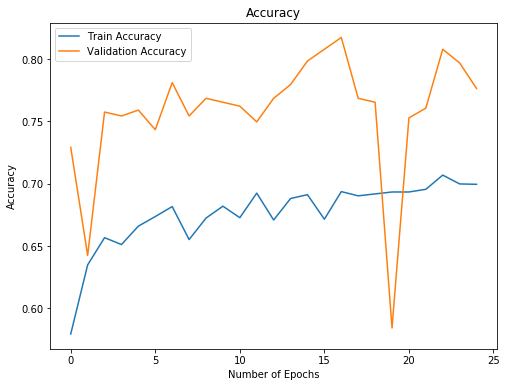

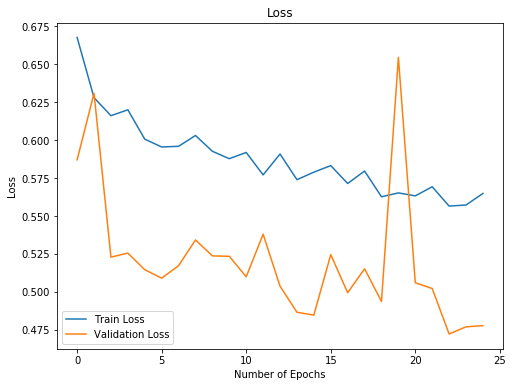

In [0]:
# Plot Accuracy/Loss
plotGraph(train_acc_list,val_acc_list,'Train Accuracy','Validation Accuracy','Accuracy')   
plotGraph(train_loss_list,val_loss_list,'Train Loss','Validation Loss',"Loss")

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_resnet_152, criterion)

Test Loss:  0.10435376

Test Accuracy: 82% (143/173)


confusion matrix: [[87 17]
 [13 56]]
F1 Score: 0.7887323943661971


Text(33.0, 0.5, 'Predicted Values')

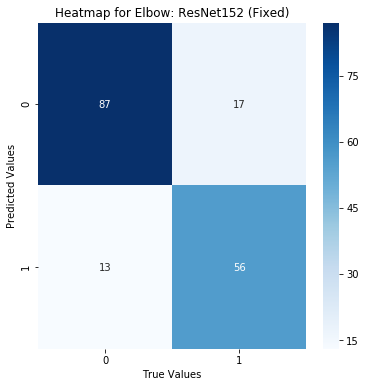

In [0]:
print("confusion matrix:",cm)
print("F1 Score:",f1_score(actual_list,predicted_list))
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap="Blues")
ax.set_title("Heatmap for Elbow: ResNet152 (Fixed)")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
#fig.savefig('/content/drive/My Drive/Thesis/Data/Wrist/heatmapResnet50.png')

In [0]:

torch.save(model_trained_resnet_152.state_dict(),os.path.join(data_dir,'fixed_resnet152_Elbow.pth'))

## VGG

In [0]:
vgg16=models.vgg16(pretrained=True)
print(vgg16.classifier[6].in_features)
# Freeze training for all layers

for param in vgg16.features.parameters():  # ASK fine tune
    param.require_grad = False
    
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=len(class_names))
#print(vgg16)
if device:
    vgg16.cuda() 

criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(vgg16.classifier[-1].parameters(), lr=0.001, momentum=0.9)

4096


In [0]:

model_trained_vgg,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(vgg16, criterion, optimizer,num_epochs=25)

Epoch 1/25
----------
train loss: 0.8621, acc: 0.5675
validate loss: 0.7693, acc: 0.5370
Epoch 2/25
----------
train loss: 0.8842, acc: 0.5795
validate loss: 0.8149, acc: 0.5323
Epoch 3/25
----------
train loss: 0.8623, acc: 0.5833
validate loss: 0.5257, acc: 0.7669
Epoch 4/25
----------
train loss: 0.8817, acc: 0.5892
validate loss: 0.6921, acc: 0.5953
Epoch 5/25
----------
train loss: 0.9283, acc: 0.5814
validate loss: 0.5449, acc: 0.7417
Epoch 6/25
----------
train loss: 0.9128, acc: 0.5967
validate loss: 0.5483, acc: 0.7276
Epoch 7/25
----------
train loss: 0.9088, acc: 0.5879
validate loss: 0.5361, acc: 0.7528
Epoch 8/25
----------
train loss: 0.8919, acc: 0.5904
validate loss: 0.6675, acc: 0.6031
Epoch 9/25
----------
train loss: 0.8825, acc: 0.5894
validate loss: 0.5232, acc: 0.7622
Epoch 10/25
----------
train loss: 0.8962, acc: 0.5822
validate loss: 0.6502, acc: 0.6378
Epoch 11/25
----------
train loss: 0.8938, acc: 0.5869
validate loss: 0.5082, acc: 0.7591
Epoch 12/25
-------

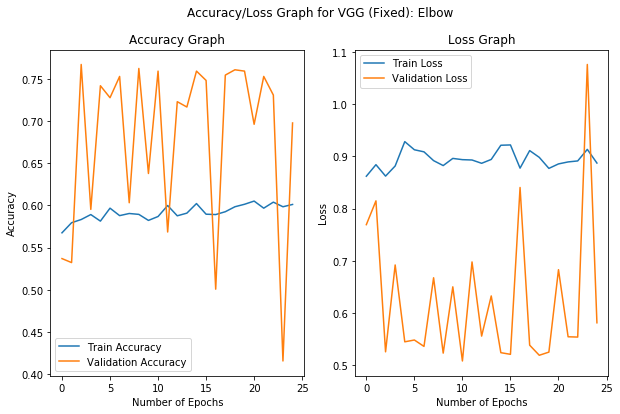

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for VGG (Fixed): Elbow")

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_vgg, criterion)


Test Loss:  0.13979067

Test Accuracy: 72% (126/173)


confusion matrix: [[68 15]
 [32 58]]
F1 Score: 0.7116564417177914


Text(33.0, 0.5, 'Predicted Values')

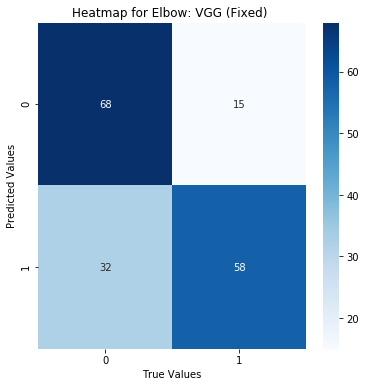

In [0]:
print("confusion matrix:",cm)
print("F1 Score:",f1_score(actual_list,predicted_list))
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap="Blues")
ax.set_title("Heatmap for Elbow: VGG (Fixed) ")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
#fig.savefig('/content/drive/My Drive/Thesis/Data/Wrist/heatmapResnet50.png')

In [0]:

torch.save(model_trained_vgg.state_dict(),os.path.join(data_dir,'fixed_vgg_Elbow.pth'))

## AlexNet

In [0]:
alexnet = models.alexnet(pretrained=True)
for param in alexnet.features.parameters():  # ASK fine tune
    param.require_grad = False
    
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs,len(class_names))

if device:
    alexnet.cuda() 
    
criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(alexnet.classifier[6].parameters(), lr=0.001, momentum=0.9)


In [0]:
model_trained_alexnet,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(alexnet, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train loss: 0.9816, acc: 0.5541
validate loss: 0.6261, acc: 0.7323
Epoch 2/25
----------
train loss: 1.0494, acc: 0.5698
validate loss: 0.5501, acc: 0.7276
Epoch 3/25
----------
train loss: 1.0319, acc: 0.5833
validate loss: 0.6749, acc: 0.6772
Epoch 4/25
----------
train loss: 1.0081, acc: 0.5784
validate loss: 0.6762, acc: 0.6583
Epoch 5/25
----------
train loss: 1.0846, acc: 0.5816
validate loss: 0.6974, acc: 0.6283
Epoch 6/25
----------
train loss: 1.1103, acc: 0.5829
validate loss: 0.6048, acc: 0.6882
Epoch 7/25
----------
train loss: 1.0396, acc: 0.5850
validate loss: 0.7074, acc: 0.6787
Epoch 8/25
----------
train loss: 1.0054, acc: 0.5883
validate loss: 0.8239, acc: 0.6268
Epoch 9/25
----------
train loss: 1.0817, acc: 0.5950
validate loss: 0.6862, acc: 0.7228
Epoch 10/25
----------
train loss: 1.1380, acc: 0.5848
validate loss: 0.6410, acc: 0.6614
Epoch 11/25
----------
train loss: 1.1552, acc: 0.5749
validate loss: 0.6004, acc: 0.7496
Epoch 12/25
-------

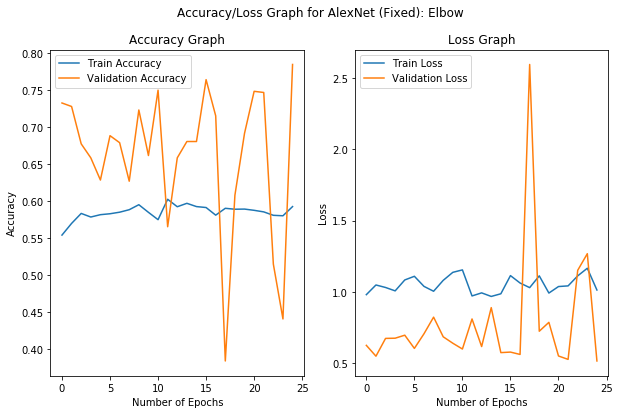

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for AlexNet (Fixed): Elbow")

Test Loss:  0.1678421

Test Accuracy: 73% (128/173)
confusion matrix: [[91 36]
 [ 9 37]]
F1 Score: 0.6218487394957983


Text(33.0, 0.5, 'Predicted Values')

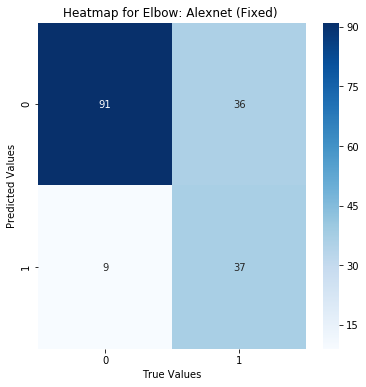

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_alexnet, criterion)
print("confusion matrix:",cm)
print("F1 Score:",f1_score(actual_list,predicted_list))
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap="Blues")
ax.set_title("Heatmap for Elbow: Alexnet (Fixed) ")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
#fig.savefig('/content/drive/My Drive/Thesis/Data/Wrist/heatmapResnet50.png')

In [0]:
# Save Model
torch.save(model_trained_alexnet.state_dict(),os.path.join(data_dir,'fixed_alexnet_Elbow.pth'))

## GoogleNet

In [0]:
google = models.inception_v3(pretrained=True) 
# Here you are loading the state_dict or weights and biases of the pre-trained inception network
num_ftrs = google.fc.in_features 
for param in google.parameters():  # ASK fine tune
    param.require_grad = False
# in_features are the inputs for the linear layer
# fc means fully connected layer

google.fc = nn.Linear(num_ftrs,2)
# here 2 is your number of classes (ants and bees)

google = google.cuda()
# device is either CPU or GPU
# So, here it is uploading the model to CPU or GPU for processing

criterion = nn.CrossEntropyLoss()
# Calculates the loss
google.aux_logits=False
optimizer_ft = optim.SGD(google.fc.parameters(), lr=0.0001, momentum=0.9)


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:00<00:00, 141126528.00it/s]


In [0]:
model_trained_google,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(google, criterion, optimizer_ft, num_epochs=25)

Epoch 1/25
----------
train loss: 0.6784, acc: 0.5778
validate loss: 0.6313, acc: 0.6709
Epoch 2/25
----------
train loss: 0.6599, acc: 0.6121
validate loss: 0.6074, acc: 0.6835
Epoch 3/25
----------
train loss: 0.6429, acc: 0.6404
validate loss: 0.5873, acc: 0.6945
Epoch 4/25
----------
train loss: 0.6428, acc: 0.6444
validate loss: 0.5702, acc: 0.7307
Epoch 5/25
----------
train loss: 0.6265, acc: 0.6532
validate loss: 0.5765, acc: 0.7197
Epoch 6/25
----------
train loss: 0.6293, acc: 0.6499
validate loss: 0.5823, acc: 0.7134
Epoch 7/25
----------
train loss: 0.6274, acc: 0.6534
validate loss: 0.5716, acc: 0.7244
Epoch 8/25
----------
train loss: 0.6206, acc: 0.6623
validate loss: 0.5637, acc: 0.7354
Epoch 9/25
----------
train loss: 0.6208, acc: 0.6633
validate loss: 0.5707, acc: 0.7276
Epoch 10/25
----------
train loss: 0.6184, acc: 0.6671
validate loss: 0.5628, acc: 0.7291
Epoch 11/25
----------
train loss: 0.6264, acc: 0.6507
validate loss: 0.5974, acc: 0.6898
Epoch 12/25
-------

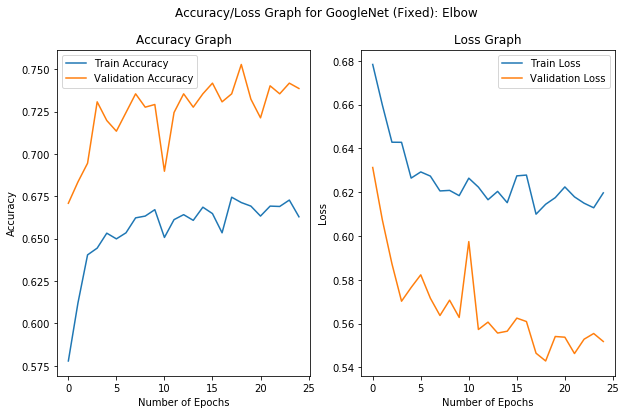

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for GoogleNet (Fixed): Elbow")

Test Loss:  0.13834806

Test Accuracy: 71% (123/173)
confusion matrix: [[87 37]
 [13 36]]
F1 Score: 0.5901639344262294


Text(33.0, 0.5, 'Predicted Values')

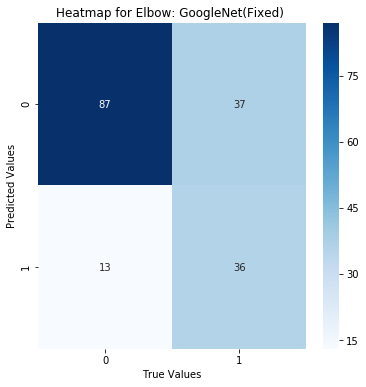

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_google, criterion)
print("confusion matrix:",cm)
print("F1 Score:",f1_score(actual_list,predicted_list))
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap="Blues")
ax.set_title("Heatmap for Elbow: GoogleNet(Fixed) ")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
#fig.savefig('/content/drive/My Drive/Thesis/Data/Wrist/heatmapResnet50.png')

In [0]:
# Save Model
torch.save(model_trained_google.state_dict(),os.path.join(data_dir,'fixed_google_elbow.pth'))

# FineTunning

## ResNet50

In [0]:
model_resnet_50_fine = models.resnet50(pretrained=True).cuda()
  
model_resnet_50_fine.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).cuda()
 
criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(model_resnet_50_fine.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model_resnet.fc.parameters())

In [0]:
model_trained_resnet_50_fine,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(model_resnet_50_fine, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train loss: 0.5837, acc: 0.6942
validate loss: 0.4229, acc: 0.8236
Epoch 2/25
----------
train loss: 0.5219, acc: 0.7534
validate loss: 0.4055, acc: 0.8299
Epoch 3/25
----------
train loss: 0.5067, acc: 0.7559
validate loss: 0.3935, acc: 0.8614
Epoch 4/25
----------
train loss: 0.4859, acc: 0.7648
validate loss: 0.4331, acc: 0.8535
Epoch 5/25
----------
train loss: 0.4629, acc: 0.7826
validate loss: 0.3479, acc: 0.8551
Epoch 6/25
----------
train loss: 0.4711, acc: 0.7790
validate loss: 0.3749, acc: 0.8504
Epoch 7/25
----------
train loss: 0.4628, acc: 0.7832
validate loss: 0.3354, acc: 0.8630
Epoch 8/25
----------
train loss: 0.4498, acc: 0.7914
validate loss: 0.3519, acc: 0.8535
Epoch 9/25
----------
train loss: 0.4398, acc: 0.7971
validate loss: 0.3657, acc: 0.8520
Epoch 10/25
----------
train loss: 0.4424, acc: 0.7969
validate loss: 0.3603, acc: 0.8457
Epoch 11/25
----------
train loss: 0.4326, acc: 0.7984
validate loss: 0.3903, acc: 0.8126
Epoch 12/25
-------

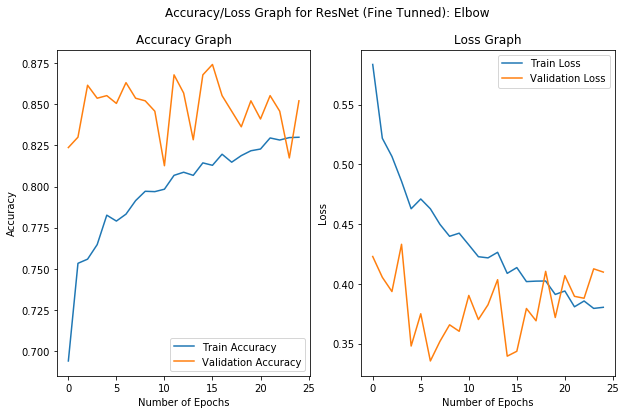

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for ResNet (Fine Tunned): Elbow")

Test Loss:  0.061067555

Test Accuracy: 89% (155/173)
confusion matrix: [[95 13]
 [ 5 60]]
F1 Score: 0.8695652173913043


Text(33.0, 0.5, 'Predicted Values')

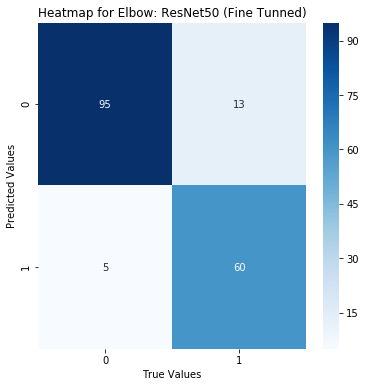

In [0]:
cm,predicted_list, actual_list=testModel(model_trained_resnet_50_fine, criterion)
print("confusion matrix:",cm)
print("F1 Score:",f1_score(actual_list,predicted_list))
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap='Blues')
ax.set_title("Heatmap for Elbow: ResNet50 (Fine Tunned)")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
#fig.savefig('/content/drive/My Drive/Thesis/Data/Wrist/heatmapResnet50.png')

In [0]:
# Save Model
torch.save(model_trained_resnet_50_fine.state_dict(),os.path.join(data_dir,'resnet50_Elbow_1305.pth'))

## ResNet152

In [0]:
model_resnet_152_fine = models.resnet152(pretrained=True).cuda()
  
model_resnet_152_fine.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).cuda()
 
criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(model_resnet_152_fine.fc.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model_resnet.fc.parameters())

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:02, 83201394.24it/s]


In [0]:
model_trained_resnet_152_fine,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(model_resnet_152_fine, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train loss: 0.6415, acc: 0.6358
validate loss: 0.5448, acc: 0.7480
Epoch 2/25
----------
train loss: 0.6136, acc: 0.6662
validate loss: 0.5510, acc: 0.7433
Epoch 3/25
----------
train loss: 0.5946, acc: 0.6929
validate loss: 0.5159, acc: 0.7543
Epoch 4/25
----------
train loss: 0.5871, acc: 0.6910
validate loss: 0.4933, acc: 0.7701
Epoch 5/25
----------
train loss: 0.5720, acc: 0.7099
validate loss: 0.4964, acc: 0.7732
Epoch 6/25
----------
train loss: 0.5772, acc: 0.7034
validate loss: 0.5102, acc: 0.7512
Epoch 7/25
----------
train loss: 0.5706, acc: 0.7087
validate loss: 0.4820, acc: 0.7890
Epoch 8/25
----------
train loss: 0.5728, acc: 0.7032
validate loss: 0.5081, acc: 0.7606
Epoch 9/25
----------
train loss: 0.5616, acc: 0.7125
validate loss: 0.4779, acc: 0.7795
Epoch 10/25
----------
train loss: 0.5691, acc: 0.7045
validate loss: 0.4660, acc: 0.7906
Epoch 11/25
----------
train loss: 0.5594, acc: 0.7223
validate loss: 0.4706, acc: 0.7906
Epoch 12/25
-------

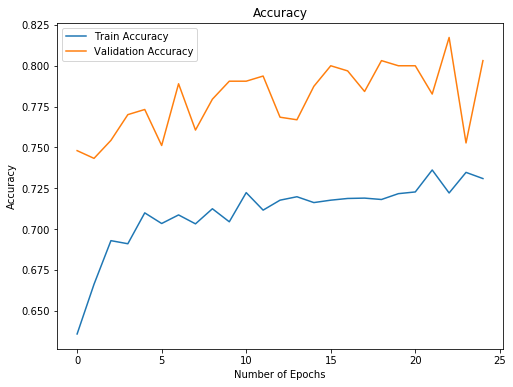

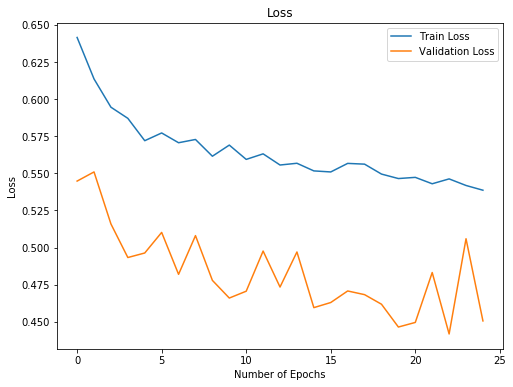

In [0]:
# Plot Accuracy/Loss
plotGraph(train_acc_list,val_acc_list,'Train Accuracy','Validation Accuracy','Accuracy')
plotGraph(train_loss_list,val_loss_list,'Train Loss','Validation Loss',"Loss")

Test Loss:  0.105274476

Test Accuracy: 78% (136/173)
confusion matrix: [[94 31]
 [ 6 42]]
F1 Score: 0.6942148760330579


Text(33.0, 0.5, 'Predicted Values')

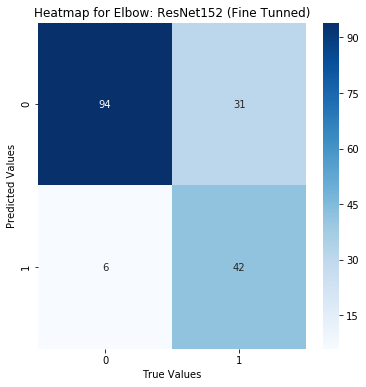

In [0]:
cm,predicted_list, actual_list=testModel(model_resnet_152_fine, criterion)
print("confusion matrix:",cm)
print("F1 Score:",f1_score(actual_list,predicted_list))
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap='Blues')
ax.set_title("Heatmap for Elbow: ResNet152 (Fine Tunned)")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
#fig.savefig('/content/drive/My Drive/Thesis/Data/Wrist/heatmapResnet50.png')

In [0]:
# Save Model
torch.save(model_trained_resnet_152_fine.state_dict(),os.path.join(data_dir,'fine_resnet152_Elbow.pth'))

## VGG

In [0]:
vgg16_fine=models.vgg16(pretrained=True)
print(vgg16_fine.classifier[6].in_features)
    
vgg16_fine.classifier[-1] =nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features=4096, out_features=len(class_names)))
#print(vgg16)
if device:
    vgg16_fine.cuda() 

criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(vgg16_fine.parameters(), lr=0.001, momentum=0.9)

4096


In [0]:
model_trained_vgg_fine,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(vgg16_fine, criterion, optimizer,num_epochs=25)

Epoch 1/25
----------
train loss: 0.6926, acc: 0.5652
validate loss: 0.6114, acc: 0.6898
Epoch 2/25
----------
train loss: 0.6192, acc: 0.6612
validate loss: 0.4437, acc: 0.8488
Epoch 3/25
----------
train loss: 0.5574, acc: 0.7345
validate loss: 0.4638, acc: 0.8283
Epoch 4/25
----------
train loss: 0.5186, acc: 0.7547
validate loss: 0.4437, acc: 0.8551
Epoch 5/25
----------
train loss: 0.5092, acc: 0.7540
validate loss: 0.3656, acc: 0.8661
Epoch 6/25
----------
train loss: 0.5053, acc: 0.7566
validate loss: 0.3647, acc: 0.8630
Epoch 7/25
----------
train loss: 0.4870, acc: 0.7708
validate loss: 0.3880, acc: 0.8787
Epoch 8/25
----------
train loss: 0.4915, acc: 0.7650
validate loss: 0.3564, acc: 0.8772
Epoch 9/25
----------
train loss: 0.4758, acc: 0.7837
validate loss: 0.3839, acc: 0.8535
Epoch 10/25
----------
train loss: 0.4656, acc: 0.7801
validate loss: 0.3608, acc: 0.8709
Epoch 11/25
----------
train loss: 0.4717, acc: 0.7816
validate loss: 0.3583, acc: 0.8693
Epoch 12/25
-------

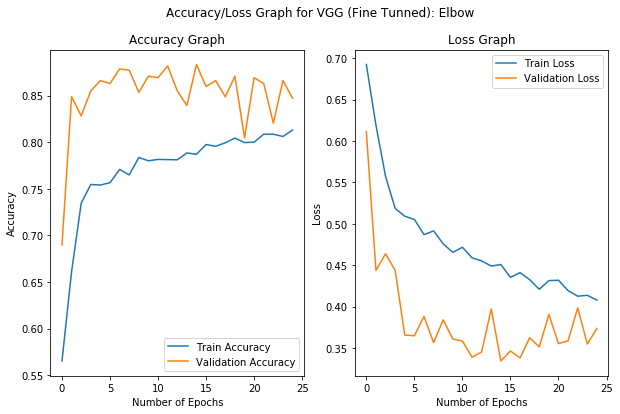

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for VGG (Fine Tunned): Elbow")

Test Loss:  0.08013673

Test Accuracy: 85% (148/173)
confusion matrix: [[97 22]
 [ 3 51]]
F1 Score: 0.8031496062992127


Text(33.0, 0.5, 'Predicted Values')

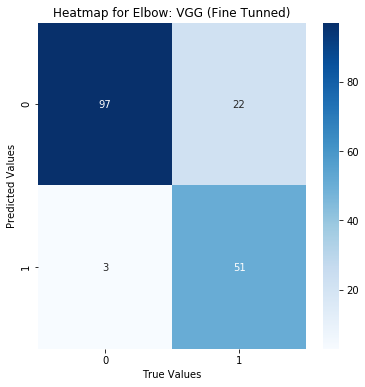

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_vgg_fine, criterion)
print("confusion matrix:",cm)
print("F1 Score:",f1_score(actual_list,predicted_list))
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap='Blues')
ax.set_title("Heatmap for Elbow: VGG (Fine Tunned)")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
#fig.savefig('/content/drive/My Drive/Thesis/Data/Wrist/heatmapResnet50.png')


In [0]:
# Save Model
  torch.save(model_trained_vgg_fine.state_dict(),os.path.join(data_dir,'fine_vgg_Elbow.pth'))

##AlexNet

In [0]:
alexnet_fine = models.alexnet(pretrained=True)

num_ftrs = alexnet_fine.classifier[6].in_features
alexnet_fine.classifier[6] = nn.Linear(num_ftrs,len(class_names))

if device:
    alexnet_fine.cuda() 
    
criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(alexnet_fine.parameters(), lr=0.001, momentum=0.9)


In [0]:
model_trained_alexnet_fine,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(alexnet_fine, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train loss: 0.6817, acc: 0.5738
validate loss: 0.6127, acc: 0.6646
Epoch 2/25
----------
train loss: 0.6610, acc: 0.6039
validate loss: 0.6133, acc: 0.6740
Epoch 3/25
----------
train loss: 0.6453, acc: 0.6171
validate loss: 0.5985, acc: 0.6772
Epoch 4/25
----------
train loss: 0.6254, acc: 0.6509
validate loss: 0.5655, acc: 0.7165
Epoch 5/25
----------
train loss: 0.6166, acc: 0.6564
validate loss: 0.6358, acc: 0.6409
Epoch 6/25
----------
train loss: 0.6113, acc: 0.6526
validate loss: 0.4632, acc: 0.8094
Epoch 7/25
----------
train loss: 0.5918, acc: 0.6847
validate loss: 0.4736, acc: 0.8110
Epoch 8/25
----------
train loss: 0.5675, acc: 0.7095
validate loss: 0.4796, acc: 0.7732
Epoch 9/25
----------
train loss: 0.5553, acc: 0.7141
validate loss: 0.4483, acc: 0.8283
Epoch 10/25
----------
train loss: 0.5497, acc: 0.7251
validate loss: 0.4173, acc: 0.8457
Epoch 11/25
----------
train loss: 0.5478, acc: 0.7232
validate loss: 0.4483, acc: 0.8394
Epoch 12/25
-------

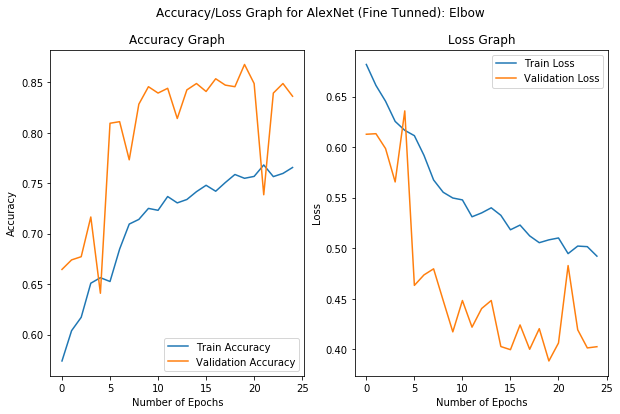

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for AlexNet (Fine Tunned): Elbow")

Test Loss:  0.09093132

Test Accuracy: 83% (144/173)
confusion matrix: [[97 26]
 [ 3 47]]
F1 Score: 0.7642276422764229


Text(33.0, 0.5, 'Predicted Values')

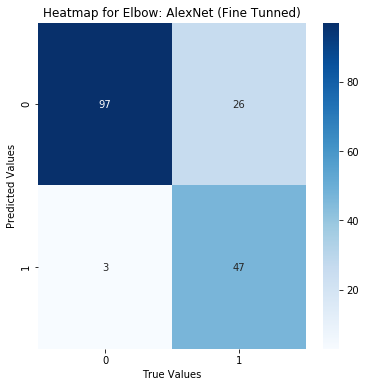

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_alexnet_fine, criterion)
print("confusion matrix:",cm)
print("F1 Score:",f1_score(actual_list,predicted_list))
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap='Blues')
ax.set_title("Heatmap for Elbow: AlexNet (Fine Tunned)")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
#fig.savefig('/content/drive/My Drive/Thesis/Data/Wrist/heatmapResnet50.png')



In [0]:
# Save Model
torch.save(model_trained_alexnet_fine.state_dict(),os.path.join(data_dir,'fine_alexnet_Elbow.pth'))

## GoogleNet

In [0]:
google_fine = models.inception_v3(pretrained=True) 
# Here you are loading the state_dict or weights and biases of the pre-trained inception network
num_ftrs = google_fine.fc.in_features 

# in_features are the inputs for the linear layer
# fc means fully connected layer

google_fine.fc = nn.Linear(num_ftrs,2)
# here 2 is your number of classes (ants and bees)

google_fine = google_fine.cuda()
# device is either CPU or GPU
# So, here it is uploading the model to CPU or GPU for processing

criterion = nn.CrossEntropyLoss()
# Calculates the loss
google_fine.aux_logits=False
optimizer_ft = optim.SGD(google_fine.parameters(), lr=0.0001, momentum=0.9)
# lr = learning rate and implements the optimization algorithms (here SGD)
# To compute gradients

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# used after calculating the gradient

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:01<00:00, 95784716.44it/s]


In [0]:
model_trained_google_fine,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(google_fine, criterion, optimizer_ft, num_epochs=25)

Epoch 1/25
----------
train loss: 0.6759, acc: 0.5864
validate loss: 0.5752, acc: 0.7339
Epoch 2/25
----------
train loss: 0.6190, acc: 0.6677
validate loss: 0.5072, acc: 0.7858
Epoch 3/25
----------
train loss: 0.5861, acc: 0.6917
validate loss: 0.4744, acc: 0.7953
Epoch 4/25
----------
train loss: 0.5630, acc: 0.7114
validate loss: 0.4432, acc: 0.8299
Epoch 5/25
----------
train loss: 0.5462, acc: 0.7217
validate loss: 0.4324, acc: 0.8236
Epoch 6/25
----------
train loss: 0.5430, acc: 0.7332
validate loss: 0.4306, acc: 0.8315
Epoch 7/25
----------
train loss: 0.5331, acc: 0.7398
validate loss: 0.4363, acc: 0.8189
Epoch 8/25
----------
train loss: 0.5269, acc: 0.7421
validate loss: 0.4166, acc: 0.8315
Epoch 9/25
----------
train loss: 0.5298, acc: 0.7423
validate loss: 0.4513, acc: 0.8110
Epoch 10/25
----------
train loss: 0.5271, acc: 0.7475
validate loss: 0.4121, acc: 0.8425
Epoch 11/25
----------
train loss: 0.5191, acc: 0.7473
validate loss: 0.4081, acc: 0.8173
Epoch 12/25
-------

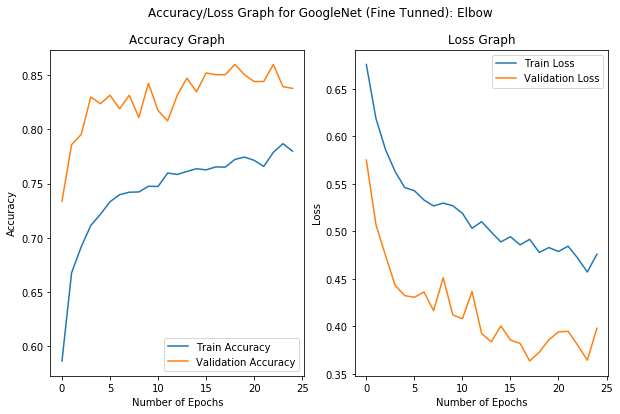

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for GoogleNet (Fine Tunned): Elbow")

Test Loss:  0.07582548

Test Accuracy: 87% (152/173)
confusion matrix: [[98 19]
 [ 2 54]]
F1 Score: 0.8372093023255813


Text(33.0, 0.5, 'Predicted Values')

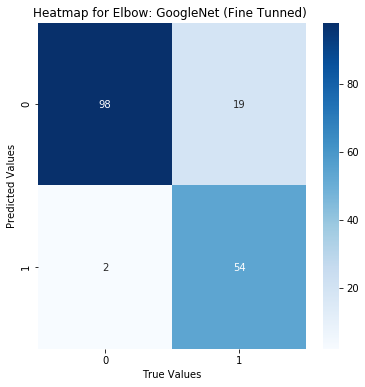

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_google_fine, criterion)
print("confusion matrix:",cm)
print("F1 Score:",f1_score(actual_list,predicted_list))
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap="Blues")
ax.set_title("Heatmap for Elbow: GoogleNet (Fine Tunned) ")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
#fig.savefig('/content/drive/My Drive/Thesis/Data/Wrist/heatmapResnet50.png')

In [0]:
# Save Model
torch.save(model_trained_google_fine.state_dict(),os.path.join(data_dir,'fine_google_elbow.pth'))